### Problem 4
We have multiple robots that can generate point clouds such as those coming from a RealSense camera. In many cases we want to use the robots to detect objects in its enviroment. We provide three data files:

(a) Empty2.asc which containts a data for an empty table<br>
(b) TableWithObjects2.asc contains point cloud for a cluttered table<br>
(c) hallway1b.asc contains data from a hallway<br>

Each file has the point cloud file in a format with each line contains xi yi zi. You can use np.loadtxt to load a pointcloud into a numpy array.


### Problem 4: Part 1
Provide a method to estimate the plane parameter for the table. Test it both with the empty and cluttered table. Describe how you filter out the data from the objects. You have to be able to estimate the table parameters in the presence of clutter.

**Solution:**

&emsp;The general equation of a plane can be written as follows:<br><br>

<center>$a(x - x_{0}) + b(y - y_{0}) + c(z - z_{0}) = 0$<center><br>

<center>$ax + by + cz = ax_{0} + by_{0} + cz_{0}; d = ax_{0} + by_{0} + cz_{0}$<center><br>

<center>$ax + by + cz = d$<center><br>

&emsp;where,

&emsp;&emsp;&emsp;$n$ is the normal vector of the plane, $<a, b, c>$.

&emsp;The plane equation can also be re-written in this form:<br><br>

<center>$ax + by - d = -cz$<center><br>

<center>$-\frac{a}{c}x - \frac{b}{c}y + \frac{d}{c} = z$<center><br>

<center>$Ax + By + C = z$<center><br>

&emsp;The re-written normal vector of the plane, $n$ became $<A, B, -1>$.

&emsp;The distance between a point and the plane, $d$ can be calculated as shown below:<br><br>

<center>$v = \begin{bmatrix} x_{i} - \bar{x} & y_{i} - \bar{y} & z_{i} - \bar{z}\end{bmatrix}$<center><br>

<center>$\hat{n} = \frac{1}{||n||}\begin{bmatrix} A \\ B \\ -1\end{bmatrix}$<center><br>

<center>$d = |v \cdot \hat{n}|$<center><br>

&emsp;where,

&emsp;&emsp;&emsp;$\hat{n}$ is the normalized normal vector of the plane

&emsp;&emsp;&emsp;$\bar{x}$ is the average of the x-coordinate 

&emsp;&emsp;&emsp;$\bar{y}$ is the average of the y-coordinate 

&emsp;&emsp;&emsp;$\bar{z}$ is the average of the z-coordinate

&emsp;&emsp;&emsp;$||n||$ is the norm of the normalized normal vector of the plane
    
&emsp;The least square plane fitting is a common method to estimate plane parameters with a given point cloud, even when the data are a little noisy. However, if the point cloud consists of many outliers, the least square fitting method might not be sufficiently robust to estimate plane parameters, and outliers will lower the quality of the plane fitting process. Hence, to improve the quality and robustness of the plane fitting process, the random sample consensus (RANSAC) plane fitting method is used to estimate the dominant plane parameters of the empty table, and the table with objects even though there are outliers in the point cloud.

&emsp; Since the RANSAC method is considered as a heuristics algorithm, the RANSAC algorithm will iterate several thousands of times to perform least square plane fitting with a set of randomly selected 3 points from the point cloud data. If the distance between a point and the fitted plane, $d$, is less than or equal to the acceptable distance between a point and the fitted plane, $d_{threshold}$, then the point is an inliers; otherwise, the point is an outlier. Besides that, the RANSAC algorithm will also count the number inliers; if the current number of inliers is larger than the previous iteration, the algorithm will store the best set of inliers and store the outliers separately. Lastly, the RANSAC algorithm will output the normalized normal vector of the fitted plane, normalized coefficient $C$, the average of the points, and the distance between a point and the plane for every points, inliers, and outliers. Hence, the RANSAC algorithm successfully filter out the outliers from the point cloud.
    



<IPython.core.display.Javascript object>


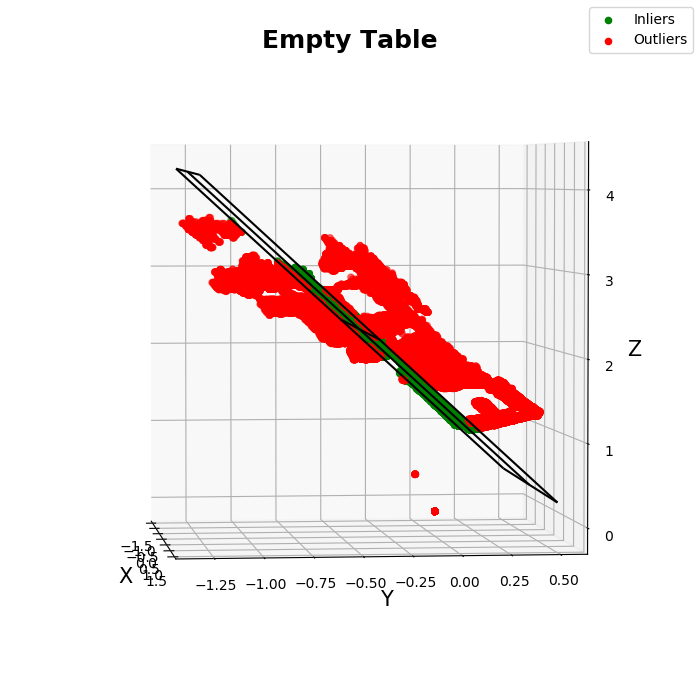

The equation of the empty table fitted plane:
-0.011647 x + -0.906377 y + -0.422310 z + 0.593806 = 0
The average distance between an inlier and the fitted plane = 0.010851


<IPython.core.display.Javascript object>


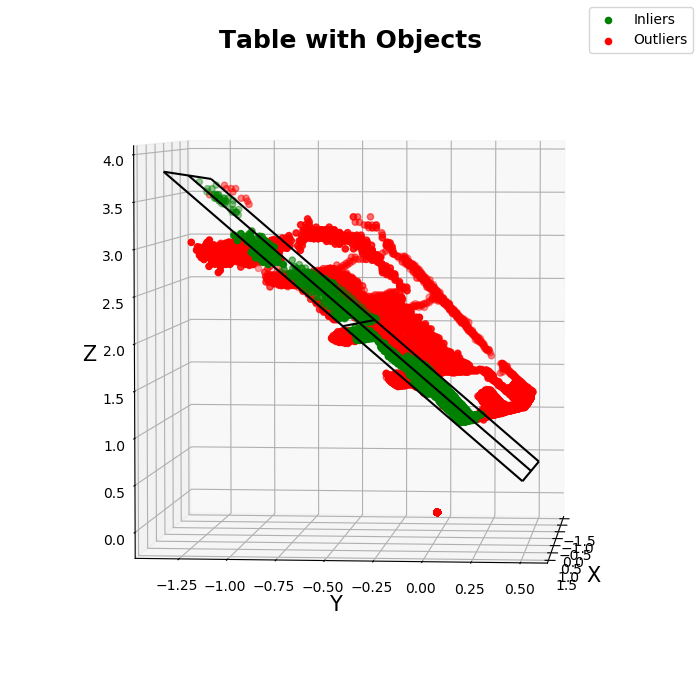

The equation of the table with objects fitted plane:
0.027658 x + -0.870000 y + -0.492276 z + 0.670482 = 0
The average distance between an inlier and the fitted plane = 0.018778


In [63]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook 

### Problem 4 Part 1: Use Random Sample Consensus (RANSAC) Algorithm for Plane Detection in 
###                   the Empty and Clutter Table Point Cloud Data


# Load Empty Table and Table with Objects files
empty_Table_pts = np.loadtxt("Empty2.asc")
table_with_Obj_pts = np.loadtxt("TableWithObjects2.asc")

# Store Empty Table x, y, z coordinates
#empty_Table_x = empty_Table_pts[:,0]
#empty_Table_y = empty_Table_pts[:,1]
#empty_Table_z = empty_Table_pts[:,2]

# Store Table with Objects x, y, z coordinates
#table_with_Obj_x = table_with_Obj_pts[:,0]
#table_with_Obj_y = table_with_Obj_pts[:,1]
#table_with_Obj_z = table_with_Obj_pts[:,2]


### User-defined Plane Fitting with Least Square Method Function
## Input  : 3D-points (m x 3)
## Outputs: normal_vec_normalized - normalized normal vector of the fitted plane (1 x 3)
##          coeff_C_normalized    - Coefficient C from the equation Ax + By + C = z 
##          mean_point            - Average of the points (1 x 3)
##          dist_pt2pl            - Distance between a point and the plane (m x 1)
def LSQ_plane_fitting(points_3D):
    
    """ 
    Pseudocode:
        1.) Construct Matrix A, [x_i, y_i, 1] (m x 3)
        2.) Construct Z Vector, [z_i] (m x 1)
        3.) Call numpy built-in linear regression to find the coefficients A, B, and C 
            from the plane equation, Ax + By + C = z
        4.) Nomalize the plane equation
        5.) Determine distance between a point and the fitted plane for every points, dist_pt2pl
        6.) Output normalized normal vector, normalized coefficient C, average point, dist_pt2pl
    """
    
    # Determine total number of points
    tot_num_pts = points_3D.shape[0]
    
    # Determine the number of dimensions
    num_dims = points_3D.shape[1]
    
    # Ax = b => An = Z
    # Initialize matrix A, [x_i, y_i, 1]
    A = np.ones((tot_num_pts, num_dims))
    A[:, 0] = points_3D[:, 0] # Pass x-coordinates to matrix A
    A[:, 1] = points_3D[:, 1] # Pass y-coordinates to matrix A
    
    # Initialize Z column vector [z_i]
    Z = np.zeros((tot_num_pts, 1))
    Z[:, 0] = points_3D[:, 2]
    
    # Perform Least Square plane fitting
    coeffs, _, _, _ = np.linalg.lstsq(A, Z, rcond = None)
    
    # Normal Vector of the Plane [A, B, -1]
    normal_vec = (coeffs[0][0], coeffs[1][0], -1)
    
    # Coefficient C
    coeff_C = coeffs[2][0]
    
    # Normalized the plane equation
    normal_norm = np.linalg.norm(normal_vec) # Norm of the normal vector
    normal_vec_normalized =  normal_vec / normal_norm
    
    # Normalized the Coefficient C
    coeff_C_normalized = coeff_C / normal_norm
    
    # Determine the mean point from the plane
    mean_point = np.mean(points_3D, axis=0)
    
    # Calculate the distance between a point and the fitted plane for every points
    dist_pt2pl = abs(np.dot(points_3D-mean_point, normal_vec_normalized))
    
    return normal_vec_normalized, coeff_C_normalized, mean_point, dist_pt2pl

### LSQ_plane_fitting() function print test
#normal_vec_normalized, coeff_C_normalized, mean_point, dist = LSQ_plane_fitting(empty_Table_pts)
#print(normal_vec_normalized, coeff_C_normalized, mean_point, dist)


### User-defined Random Sample Consensus (RANSAC) Function
## Input  : 3D-points (m x 3)
##          Maximum Iterations
##          Maximum Threshold for the Distance between a point and the plane
## Outputs: RanSaC_normal_vec_normalized - RanSaC normalized normal vector of the fitted plane (1 x 3)
##          RanSaC_coeff_C_normalized    - RanSaC Coefficient C from the equation Ax + By + C = z 
##          RanSaC_mean_point            - RanSaC Average of the points (1 x 3)
##          RanSaC_dist_pt2pl            - RanSaC Distance between a point and the plane (m x 1)
##          inlier_pts                   - Points that are inliers
##          outlier_pts                  - Points that are outliers
def RanSaC_algorithm(points_3D, max_iterations, dist_pt2pl_threshold):
    
    """ 
    Pseudocode:
        1.) Initialize the maximum number of inliers and best inliers set
        2.) Start the iteration till it reaches maximum iterations with for loop
            a.) Pick 3 random points
            b.) Perform least square plane fitting with those random n points
            c.) Check the distance threshold for every points
            d.) Determine total number of points that are within the distance threshold
            e.) Store the total number inliers and the best set of inliers if it is more than the previous one
        3.) Perform another least square plane fitting with best set of inliers
        4.) Outputs the Output normalized normal vector, normalized coefficient C, average point, dist_pt2pl from the
            best set of inlier
    """
    
    # Initialize the maximum number of inliers
    max_num_Inliers = None
    
    # Initialize the best set of inliers
    best_set_Inliers = None
    
    # Initialize the set of outlier
    set_Outliers = None
    
    # Start the iteration to perform RanSaC to discard outliers
    for iteration in range(0, max_iterations):
        
        # Pick 3 Random Points from the set of the points_3D
        rand_points = points_3D[random.sample(range(0,points_3D.shape[0]), 3),:]
        
        # Perform least square plane fitting with those randomly selected points.
        normal_vec_normalized, coeff_C_normalized, mean_point, _ = LSQ_plane_fitting(rand_points)
        
        # Determine the distance between a point and the plane.
        dist_pt2pl = abs(np.dot(points_3D - mean_point, normal_vec_normalized))
        
        # Store the inlier index that are equal or below the distance threshold
        inliers_index = np.where(dist_pt2pl <= dist_pt2pl_threshold)
        
        # Store the outlier index
        outliers_index = np.where(dist_pt2pl > dist_pt2pl_threshold)
        
        # Count the Total number of inliers
        num_Inliers = inliers_index[0].shape[0]
        
        # If the score is better than the previous iteration
        if (max_num_Inliers is None) or (num_Inliers > max_num_Inliers):
            
            # Store the index of the inliers
            best_set_Inliers = inliers_index
            
            # Store the index of the outliers
            set_Outliers = outliers_index
            
            # Store the new maximum number of inliers
            max_num_Inliers = num_Inliers
    
    # Store outliers
    outlier_pts = points_3D[set_Outliers[0], :]
    
    # Store only points that are inliers
    inlier_pts = points_3D[best_set_Inliers[0], :]
    
    # Perform another least square plane fitting with those inlier points.
    RanSaC_normal_vec_normalized, RanSaC_coeff_C_normalized, RanSaC_mean_point, RanSaC_dist_pt2pl = LSQ_plane_fitting(inlier_pts)
        
    return RanSaC_normal_vec_normalized, RanSaC_coeff_C_normalized, RanSaC_mean_point, RanSaC_dist_pt2pl, inlier_pts, outlier_pts


### User-defined display of the plane plot function
## Input  : Inliers 
##          Outliers
##          3D-points (m x 3)
##          Normal Vector
##          Average point
##          Graph title in string
## Outputs: None
def display_plane_plot(inlier_pts, outlier_pts, points_3D, normal_vec, mean_point, graph_title):
    
    # Initialize figure object and set figure size
    CSE_276C_fig = plt.figure(figsize=(7,7))
    # Initialize axes object
    CSE_276C_ax1 = Axes3D(CSE_276C_fig)
    
    # Plot scatter points
    # Inliers are green
    CSE_276C_ax1.scatter(inlier_pts[:,0], inlier_pts[:, 1], inlier_pts[:, 2], c = 'green', label = "Inliers")
    # Outliers are red
    CSE_276C_ax1.scatter(outlier_pts[:,0], outlier_pts[:, 1], outlier_pts[:, 2], c = 'red', label = "Outliers")
    plt.legend(loc="upper right") # Legend location
    
    # Plot the fitted plane
    X_coord = np.linspace(min(points_3D[:,0]),max(points_3D[:,0]),3) # Determine the x-axis limit
    Y_coord = np.linspace(min(points_3D[:,1]),max(points_3D[:,1]),3) # Determine the y-axis limit
    x_coord, y_coord = np.meshgrid(X_coord, Y_coord)
    z_coord = -(normal_vec[0] / normal_vec[2]) * x_coord - (normal_vec[1]/normal_vec[2]) * y_coord + (np.dot(normal_vec, mean_point)/normal_vec[2])
    CSE_276C_ax1.plot_wireframe(x_coord,y_coord,z_coord,color='k')
    
    # Label Axis
    CSE_276C_ax1.set_xlabel("X", fontsize = 15)
    CSE_276C_ax1.set_ylabel("Y", fontsize = 15)
    CSE_276C_ax1.set_zlabel("Z", fontsize = 15)
    
    # Plot title
    plt.title(graph_title, fontsize = 18, fontweight = "bold")
    
    # Show Plot
    plt.show()
    
    # Change View of the Plot
    #CSE_276C_ax1.view_init(0, 0)
    
    """# Initialize axes object
    CSE_276C_ax2 = CSE_276C_fig.add_subplot(222, projection='3d')
    
    # Plot scatter points
    # Inliers are green
    CSE_276C_ax2.scatter(inlier_pts[:,0], inlier_pts[:, 1], inlier_pts[:, 2], c = 'green')
    # Outliers are red
    CSE_276C_ax2.scatter(outlier_pts[:,0], outlier_pts[:, 1], outlier_pts[:, 2], c = 'red')
    
    # Plot the fitted plane
    x_coord, y_coord = np.meshgrid(X_coord, Y_coord)
    z_coord = -(normal_vec[0] / normal_vec[2]) * x_coord - (normal_vec[1]/normal_vec[2]) * y_coord + (np.dot(normal_vec, mean_point)/normal_vec[2])
    CSE_276C_ax2.plot_wireframe(x_coord,y_coord,z_coord,color='k')
    
    # Label Axis
    CSE_276C_ax2.set_xlabel("X", fontsize = 8)
    CSE_276C_ax2.set_ylabel("Y", fontsize = 8)
    CSE_276C_ax2.set_zlabel("Z", fontsize = 8)
    
    # Plot title
    plt.title(graph_title, fontsize = 10, fontweight = "bold")   
    CSE_276C_ax2.view_init(0, 0)"""
    
    
# Plane Fitting for the Empty Table with RanSaC
RanSaC_normal_vec_normalized, RanSaC_coeff_C_normalized, RanSaC_mean_point, RanSaC_dist_pt2pl, inlier_pts, outlier_pts = RanSaC_algorithm(empty_Table_pts, 2000, 0.05)

# Plane Fitting for the Table with Objects with RanSaC
RanSaC_normal_vec_normalized2, RanSaC_coeff_C_normalized2, RanSaC_mean_point2, RanSaC_dist_pt2pl2, inlier_pts2, outlier_pts2 = RanSaC_algorithm(table_with_Obj_pts, 5000, 0.05)
    

# Display Plane Fitting Plot for the Empty Table
display_plane_plot(inlier_pts, outlier_pts, empty_Table_pts, RanSaC_normal_vec_normalized, RanSaC_mean_point, "Empty Table")
# Show the plane equation for the Empty Table
print("The equation of the empty table fitted plane:")
print("%f x + %f y + %f z + %f = 0" % (RanSaC_normal_vec_normalized[0], RanSaC_normal_vec_normalized[1], RanSaC_normal_vec_normalized[2], RanSaC_coeff_C_normalized))
print("The average distance between an inlier and the fitted plane = %f" % (np.mean(RanSaC_dist_pt2pl)))

# Display Plane Fitting Plot for Table with Objects
display_plane_plot(inlier_pts2, outlier_pts2, table_with_Obj_pts, RanSaC_normal_vec_normalized2, RanSaC_mean_point2, "Table with Objects")
# Show the plane equation for Table with Objects
print("The equation of the table with objects fitted plane:")
print("%f x + %f y + %f z + %f = 0" % (RanSaC_normal_vec_normalized2[0], RanSaC_normal_vec_normalized2[1], RanSaC_normal_vec_normalized2[2], RanSaC_coeff_C_normalized2))
print("The average distance between an inlier and the fitted plane = %f" % (np.mean(RanSaC_dist_pt2pl2)))   


### Plot samples by Professor Christensen and Dr. Wong     
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(empty_Table[:,0], empty_Table[:,1], empty_Table[:,2], color='white', edgecolors='grey', alpha=0.5)
#ax.scatter(empty_Table[:,0], empty_Table[:,1], empty_Table[:,2], c='red')
#plt.show()

After the empty table point cloud file, "Empty2.asc"  was loaded, the empty table point cloud was input to RANSAC algorithm with a maximum iteration of 2000 and $d_{dest} = 0.05$. The "Empty Table" figure above shows that the equation of the empty table fitted plane is $-0.011647 x -0.906377 y -0.422310 z + 0.593806 = 0$. The average distance between an inlier of the empty table and the plane is 0.010851, which is below the set $d_{dest}$.  Then, the table with objects point cloud, "TableWithObjects2.asc" was also loaded, the table with objects point cloud was input to the RANSAC algorithm with a maximum iteration of 5000 and $d_{dest} = 0.05$. The RANSAC algorithm ran 3000 more iteration with table with objects point cloud because there are more outlier to filter out to determine the best fitted plane. The "Table with Objects" figure above shows that the equation of the table with objects fitted plane is $0.027658 x -0.870000 y -0.492276 z + 0.670482 = 0$. The average distance between an inlier of the table with objects and the plane is 0.018778, which is below the set $d_{dest}$. 

<IPython.core.display.Javascript object>


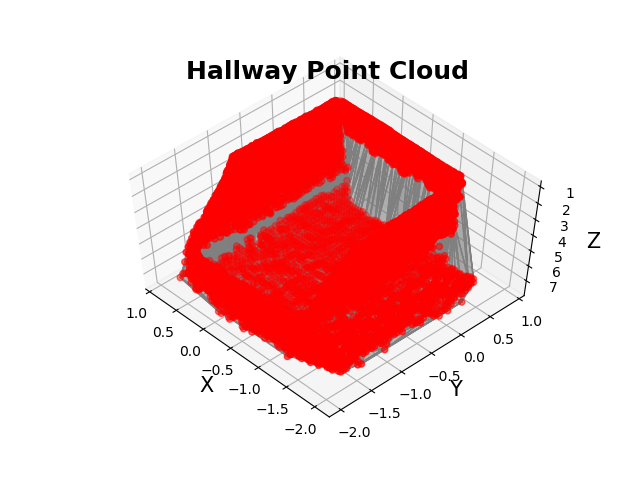

In [15]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook 

# Load Hallway files
hallway = np.loadtxt("hallway1b.asc")

### Points Cloud Plot    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(hallway[:,0], hallway[:,1], hallway[:,2], color='white', edgecolors='grey', alpha=0.5)
ax.scatter(hallway[:,0], hallway[:,1], hallway[:,2], c='red')
# Label Axis
ax.set_xlabel("X", fontsize = 15)
ax.set_ylabel("Y", fontsize = 15)
ax.set_zlabel("Z", fontsize = 15)
    
# Plot title
plt.title("Hallway Point Cloud", fontsize = 18, fontweight = "bold")

plt.show()


### Problem 4: Part 2
Describe and show how the method can be generalized to extract all the dominant planes in a relatively empty hallway.

**Solution:**

&emsp;In order to detect multiple planes in the hallway, a user-defined function, "dominant_planes_Hunter()" was created. The dominant_planes_Hunter() user-defined function will run the RANSAC algorithm with the hallway 3D point cloud and store the first plane parameters including the normal vector, coefficient $C$, mean point, etc. Then, the outliers will be stored, and re-run the RANSAC algorithm with the outliers to exclude the previous inliers. The process will be repeated another 3 times to find all the remaining dominant plane in the hallway. The RANSAC algorithm maximum iterations was set to be 10000, and the distance threshold, $d_{thres}$, to be 0.2. The planes in the hallway was plotted as shown in the figure below:

<IPython.core.display.Javascript object>


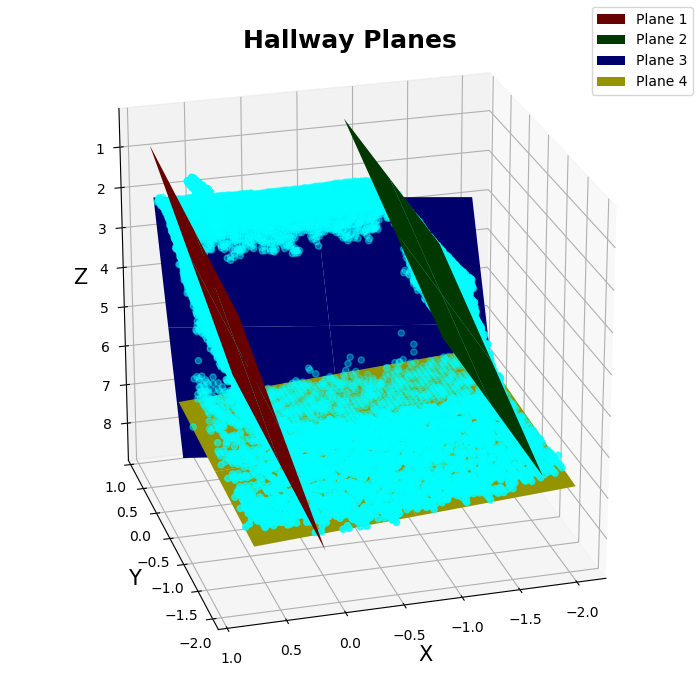

In [55]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook 

# Load Hallway files
hallway_pts = np.loadtxt("hallway1b.asc")

### User-defined dominant planes finder and plotter function
## Input  : 3D-points (m x 3) 
##          Maximum iterations for each plane (array form)
##          Maximum distance threshold for each plane (array form)
##          Number of Expected Planes
## Outputs: All the normal vectors in a list form
##          All coefficient Cs in a list form
##          All the mean points in a list form
##          All the inlier points in a list form
##          All the outlier points in a list form
def dominant_planes_Hunter(points3D, max_iterations, dist_pt2pl_thres, num_dom_pln):
    
    # Initialize figure object and set figure size
    CSE_276C_fig = plt.figure(figsize=(7,7))
        
    # Initialize axes object
    CSE_276C_ax = Axes3D(CSE_276C_fig)
    
    # Plot Point Cloud Hallway
    CSE_276C_ax.scatter(hallway_pts[:,0], hallway_pts[:,1], hallway_pts[:,2], c='cyan')
    
    # Label Axis
    CSE_276C_ax.set_xlabel("X", fontsize = 15)
    CSE_276C_ax.set_ylabel("Y", fontsize = 15)
    CSE_276C_ax.set_zlabel("Z", fontsize = 15)
    
    # Plot title
    plt.title("Hallway Planes", fontsize = 18, fontweight = "bold")
    
    # Set plot colors
    colors = ['r', 'g', 'b', 'y', 'm', 'k']
    
    # Labels
    labels = ["Plane 1", "Plane 2", "Plane 3", "Plane 4", "Plane 5", "Plane 6"]
    
    # Create empty lists that store all the normal vectors, coefficent Cs, mean points, inliers, and outliers
    # for every dominant plane
    normal_vec_ALL = []
    coeff_C_ALL = []
    mean_point_ALL = []
    inlier_pts_ALL = []
    outlier_pts_ALL = []
    
    # Initialize New Set of Point
    new_set_pts = hallway_pts
    
    for plane_ID in range(0, num_dom_pln):
        
        # Run RanSaC Plane Fitting
        normal_vec, coeff_C, mean_point, _, inlier_pts, outlier_pts = RanSaC_algorithm(new_set_pts, max_iterations[plane_ID], dist_pt2pl_thres[plane_ID])
    
        # Plot Plane
        X_coord = np.linspace(min(inlier_pts[:,0]),max(inlier_pts[:,0]),3) # Determine the x-axis limit
        Y_coord = np.linspace(min(inlier_pts[:,1]),max(inlier_pts[:,1]),3) # Determine the y-axis limit
        x_coord, y_coord = np.meshgrid(X_coord, Y_coord)
        z_coord = -(normal_vec[0] / normal_vec[2]) * x_coord - (normal_vec[1]/normal_vec[2]) * y_coord + (np.dot(normal_vec, mean_point)/normal_vec[2])
        #CSE_276C_ax.plot_wireframe(x_coord,y_coord,z_coord,color='k')
        #CSE_276C_ax.plot_wireframe(x_coord,y_coord,z_coord,color=colors[plane_ID])
        pln = CSE_276C_ax.plot_surface(x_coord,y_coord,z_coord,color=colors[plane_ID], label = labels[plane_ID])
        pln._facecolors2d = pln._facecolors3d
        pln._edgecolors2d = pln._edgecolors3d
        CSE_276C_ax.legend()
        
        # Store Plane Information to the lists
        normal_vec_ALL.append(normal_vec)
        coeff_C_ALL.append(coeff_C)
        mean_point_ALL.append(mean_point)
        inlier_pts_ALL.append(inlier_pts)
        outlier_pts_ALL.append(outlier_pts)
        
        # Store the remaining points to the new_set_pts
        new_set_pts = outlier_pts
    
    # Show plot
    plt.show()
    
    return normal_vec_ALL, coeff_C_ALL, mean_point_ALL, inlier_pts_ALL, outlier_pts_ALL

# Set parameters
max_iterations =[10000, 10000, 10000, 10000]
dist_pt2pl_thres =[0.2, 0.2, 0.2, 0.2]
num_dom_pln = 4

# Let's hunt down the planes in the hallway!
normal_vec_ALL, coeff_C_ALL, mean_point_ALL, inlier_pts_ALL, outlier_pts_ALL = dominant_planes_Hunter(hallway_pts, max_iterations, dist_pt2pl_thres, num_dom_pln)


### Plot samples by Professor Christensen and Dr. Wong     
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(hallway[:,0], hallway[:,1], hallway[:,2], color='white', edgecolors='grey', alpha=0.5)
#ax.scatter(hallway[:,0], hallway[:,1], hallway[:,2], c='red')
#plt.show()

In [58]:
# Show the 1st plane equation from the hallway
print("The equation of 1st fitted plane from the hallway:")
print("%f x + %f y + %f z + %f = 0" % (normal_vec_ALL[0][0], normal_vec_ALL[0][1], normal_vec_ALL[0][2], coeff_C_ALL[0]))

# Show the 2nd plane equation from the hallway
print("\nThe equation of 2nd fitted plane from the hallway:")
print("%f x + %f y + %f z + %f = 0" % (normal_vec_ALL[1][0], normal_vec_ALL[1][1], normal_vec_ALL[1][2], coeff_C_ALL[1]))

# Show the 3rd plane equation from the hallway
print("\nThe equation of 3rd fitted plane from the hallway:")
print("%f x + %f y + %f z + %f = 0" % (normal_vec_ALL[2][0], normal_vec_ALL[2][1], normal_vec_ALL[2][2], coeff_C_ALL[2]))

# Show the 4th plane equation from the hallway
print("\nThe equation of 4th fitted plane from the hallway:")
print("%f x + %f y + %f z + %f = 0" % (normal_vec_ALL[3][0], normal_vec_ALL[3][1], normal_vec_ALL[3][2], coeff_C_ALL[3]))

The equation of 1st fitted plane from the hallway:
-0.975413 x + -0.145478 y + -0.165546 z + 1.098832 = 0

The equation of 2nd fitted plane from the hallway:
-0.987955 x + -0.009184 y + -0.154469 z + -0.748513 = 0

The equation of 3rd fitted plane from the hallway:
-0.047033 x + -0.985149 y + -0.165134 z + 1.250932 = 0

The equation of 4th fitted plane from the hallway:
0.172249 x + -0.133171 y + -0.976010 z + 6.806987 = 0


The equations of each plane in the hallway are presented above. The RANSAC algorithm was run at a higher iterations and $d_{dest}$, which are 10000 and 0.2 for every plane in the hallway because the point cloud data in the hallway was not that clean and a little scatter. Hence, the implemented "dominant_planes_Hunter()" user-defined function that also uses the RANSAC algorithm succesfully extracted all the dominant plane from the relatively empty hallway.